In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Simple 2-layer MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Training function
def train(model, optimizer, dataloader, epochs=60, device='cpu'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss / (pbar.n + 1))



In [42]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Train with SGD
model_sgd = MLP()
opt_sgd = optim.SGD(model_sgd.parameters(), lr=0.1)
train(model_sgd, opt_sgd, train_loader)

# Flatten weights after training
weights_sgd = torch.cat([p.data.view(-1) for p in model_sgd.parameters()])


Epoch 60/60: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s, loss=0.0099] 


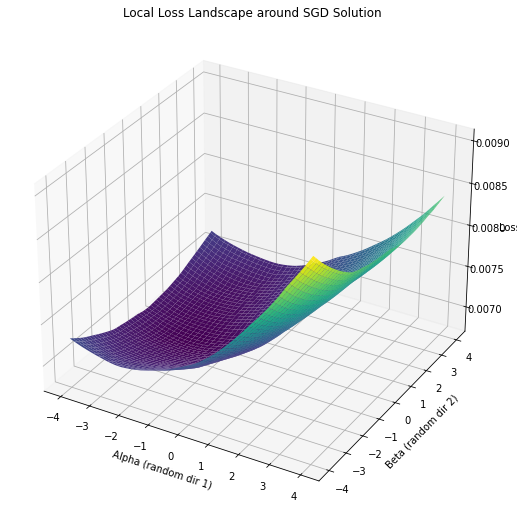

In [45]:
# Flatten weights
def get_weights(model):
    return torch.cat([p.data.view(-1) for p in model.parameters()])

def set_weights(model, flat_weights):
    idx = 0
    for p in model.parameters():
        shape = p.data.size()
        numel = p.data.numel()
        p.data = flat_weights[idx:idx+numel].view(shape).clone()
        idx += numel

# Define directions around the SGD solution
weights_sgd = get_weights(model_sgd)

# Generate two random, orthogonal directions
direction_1 = torch.randn_like(weights_sgd)
direction_1 /= direction_1.norm()

direction_2 = torch.randn_like(weights_sgd)
direction_2 -= torch.dot(direction_1, direction_2) * direction_1  # Make orthogonal
direction_2 /= direction_2.norm()

# Grid resolution
alphas = np.linspace(-4, 4, 100)  # Higher resolution
betas = np.linspace(-4, 4, 100)
loss_surface = np.zeros((len(alphas), len(betas)))

# Evaluate loss
criterion = nn.CrossEntropyLoss()
model_temp = deepcopy(model_sgd)
x_batch, y_batch = next(iter(train_loader))
x_batch, y_batch = x_batch[:256], y_batch[:256]

for i, alpha in enumerate(alphas):
    for j, beta in enumerate(betas):
        w = weights_sgd + alpha * direction_1 + beta * direction_2
        set_weights(model_temp, w)
        with torch.no_grad():
            output = model_temp(x_batch)
            loss = criterion(output, y_batch)
        loss_surface[i, j] = loss.item()

# 3D Plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

alphas_grid, betas_grid = np.meshgrid(alphas, betas)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alphas_grid, betas_grid, loss_surface, cmap=cm.viridis)
ax.set_xlabel('Alpha (random dir 1)')
ax.set_ylabel('Beta (random dir 2)')
ax.set_zlabel('Loss')
ax.set_title('Local Loss Landscape around SGD Solution')
plt.show()

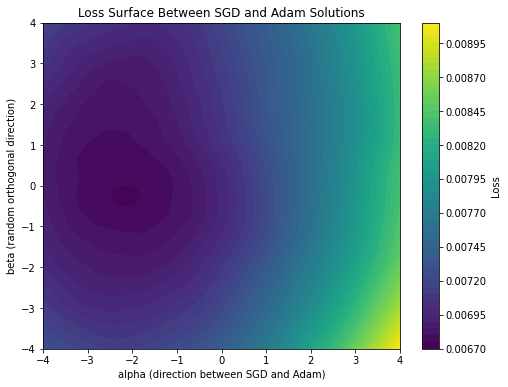

In [46]:
plt.figure(figsize=(8,6))
plt.contourf(alphas, betas, loss_surface, levels=50, cmap='viridis')
plt.colorbar(label='Loss')
plt.xlabel('alpha (direction between SGD and Adam)')
plt.ylabel('beta (random orthogonal direction)')
plt.title('Loss Surface Between SGD and Adam Solutions')
plt.show()


Computing loss surface: 100%|██████████| 51/51 [00:02<00:00, 19.96it/s]


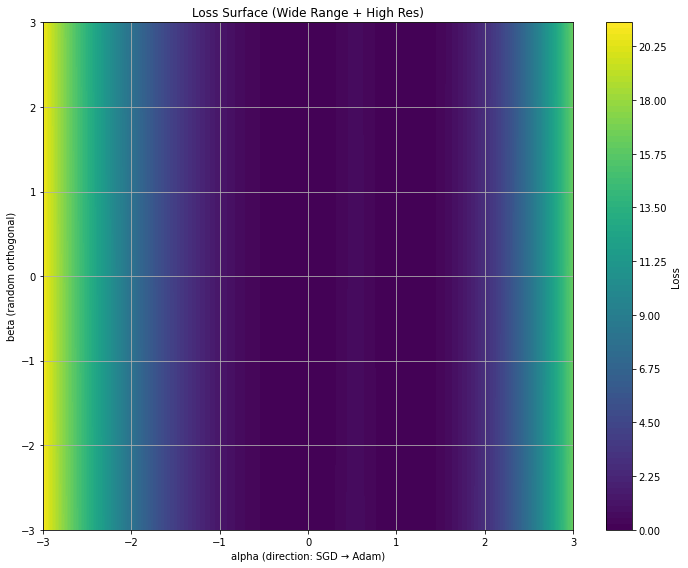

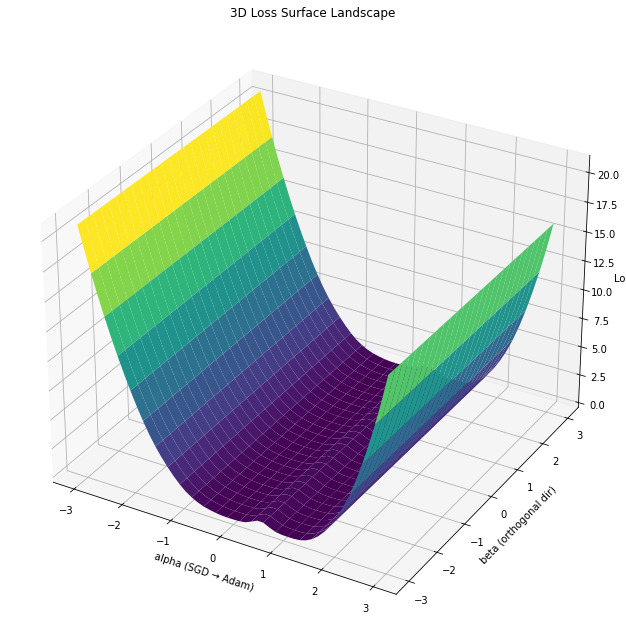

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D  # For 3D plot

# Flatten model parameters
def get_weights(model):
    return torch.cat([p.data.view(-1) for p in model.parameters()])

def set_weights(model, flat_weights):
    idx = 0
    for p in model.parameters():
        shape = p.data.size()
        numel = p.data.numel()
        p.data = flat_weights[idx:idx+numel].view(shape).clone()
        idx += numel

# Create 2D grid (more values and larger area)
grid_size = 51  # higher resolution
range_scale = 3.0  # wider range
alphas = np.linspace(-range_scale, range_scale, grid_size)
betas = np.linspace(-range_scale, range_scale, grid_size)

# Define directions in weight space
direction_1 = weights_adam - weights_sgd
direction_2 = torch.randn_like(direction_1)
direction_2 -= torch.dot(direction_1, direction_2) * direction_1 / direction_1.norm()**2
direction_2 /= direction_2.norm()

# Create loss surface grid
loss_surface = np.zeros((len(alphas), len(betas)))
criterion = nn.CrossEntropyLoss()
model_temp = deepcopy(model_sgd)

# Small batch for evaluation
x_batch, y_batch = next(iter(train_loader))
x_batch, y_batch = x_batch[:256], y_batch[:256]

# Compute loss over grid with tqdm
for i, alpha in enumerate(tqdm(alphas, desc="Computing loss surface")):
    for j, beta in enumerate(betas):
        w = weights_sgd + alpha * direction_1 + beta * direction_2
        set_weights(model_temp, w)
        with torch.no_grad():
            out = model_temp(x_batch)
            loss = criterion(out, y_batch)
        loss_surface[i, j] = loss.item()

# Meshgrid for plotting
A, B = np.meshgrid(alphas, betas)

# ✅ 2D Contour Plot (zoomed-out and denser)
plt.figure(figsize=(10, 8))
contour = plt.contourf(A, B, loss_surface.T, levels=100, cmap='viridis')
plt.colorbar(contour, label='Loss')
plt.xlabel('alpha (direction: SGD → Adam)')
plt.ylabel('beta (random orthogonal)')
plt.title('Loss Surface (Wide Range + High Res)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ 3D Surface Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, B, loss_surface.T, cmap='viridis', edgecolor='none')
ax.set_xlabel('alpha (SGD → Adam)')
ax.set_ylabel('beta (orthogonal dir)')
ax.set_zlabel('Loss')
ax.set_title('3D Loss Surface Landscape')
plt.tight_layout()
plt.show()
